In [1]:
# Stage 1: Collect Explore
# Stage 2: Annotate and convert labelme annotations to seg
# Stage 3: Find spawn location and target for reexplore (reexplore_data.json)
# Stage 4: Run reexplore for all objects, one at a time 
# Stage 5: Run label prop
# Stage 6: Run training 

In [2]:
from droidlet.dashboard.o3dviz import O3DViz
o3dviz = O3DViz(False)
o3dviz.start()

/Users/soumith/miniconda3/envs/droidlet/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Stage 1: Collect Explore to $HOME/explore_data

# Stage 3: Find spawn location and target for reexplore (reexplore_data.json) in a separate out_dir


In [4]:
import numpy as np

intrinsic_mat = np.array([[605.2880249,    0.,         319.11114502],
                         [  0. ,        605.65637207 ,239.48382568],
                         [  0.  ,         0. ,          1.        ]])
cam_transform = np.array([[ 0.91659643,  0.39410445,  0.06732512,  0.02253934],
                         [ 0.06113936,  0.02824667, -0.99772947,  0.01885885],
                         [-0.39511134,  0.91863149,  0.00179551,  1.31188133],
                         [ 0.         , 0.         , 0.        ,  1.        ]])

trans = cam_transform[0:3, 3]
rot = cam_transform[0:3, 0:3]


In [5]:
# from droidlet.lowlevel.hello_robot.hello_robot_mover import HelloRobotMover
# mover = HelloRobotMover(ip="100.95.90.42")


In [6]:

# import time
# import math

# mover.bot.set_pan_tilt(0.0, math.radians(-30))
# time.sleep(2)

# cam_transform = mover.bot.get_camera_transform().value
# intrinsic_mat = mover.cam.get_intrinsics()


# trans = cam_transform[:, 3]
# rot = cam_transform[0:3, 0:3]

# print(intrinsic_mat)
# print(cam_transform)



In [7]:
d3_40_colors_rgb: np.ndarray = np.array(
    [
        [31, 119, 180],
        [174, 199, 232],
        [255, 127, 14],
        [255, 187, 120],
        [44, 160, 44],
        [152, 223, 138],
        [214, 39, 40],
        [255, 152, 150],
        [148, 103, 189],
        [197, 176, 213],
        [140, 86, 75],
        [196, 156, 148],
        [227, 119, 194],
        [247, 182, 210],
        [127, 127, 127],
        [199, 199, 199],
        [188, 189, 34],
        [219, 219, 141],
        [23, 190, 207],
        [158, 218, 229],
        [57, 59, 121],
        [82, 84, 163],
        [107, 110, 207],
        [156, 158, 222],
        [99, 121, 57],
        [140, 162, 82],
        [181, 207, 107],
        [206, 219, 156],
        [140, 109, 49],
        [189, 158, 57],
        [231, 186, 82],
        [231, 203, 148],
        [132, 60, 57],
        [173, 73, 74],
        [214, 97, 107],
        [231, 150, 156],
        [123, 65, 115],
        [165, 81, 148],
        [206, 109, 189],
        [222, 158, 214],
    ],
    dtype=np.uint8,
) 


In [20]:
"""
Copyright (c) Facebook, Inc. and its affiliates.
"""
import numpy as np
from droidlet.lowlevel.robot_mover_utils import transform_pose
from droidlet.shared_data_structs import RGBDepth
from droidlet.shared_data_struct.rotation import (
    rotation_matrix_x,
    rotation_matrix_y,
    rotation_matrix_z,
)
from droidlet.perception.robot.visual_registration import pointcloud_registration_global, pointcloud_registration_local
import cv2
import open3d as o3d
import math
from numba import njit
from math import ceil, floor, isnan
from collections import deque, defaultdict

 # TODO: Consolidate camera intrinsics and their associated utils across locobot and habitat.
def compute_uvone(height, width):
    intrinsic_mat_inv = np.linalg.inv(intrinsic_mat)
    img_resolution = (height, width)
    img_pixs = np.mgrid[0 : img_resolution[0] : 1, 0 : img_resolution[1] : 1]
    img_pixs = img_pixs.reshape(2, -1)
    img_pixs[[0, 1], :] = img_pixs[[1, 0], :]
    uv_one = np.concatenate((img_pixs, np.ones((1, img_pixs.shape[1]))))
    uv_one_in_cam = np.dot(intrinsic_mat_inv, uv_one)
    return uv_one_in_cam, intrinsic_mat, rot, trans

def uncompute_pcd(pts, rot_cam, trans_cam, base_state, intrinsic_mat):
    translation_vector = np.array(
        [trans_cam[0] + base_state[0], trans_cam[1] + base_state[1],  trans_cam[2] + 0]
    ).reshape(-1)
    h, w = pts.shape[0], pts.shape[1]

    pts = pts - translation_vector

    roty90, rotxn90 = rotation_matrix_y(90), rotation_matrix_x(-90)
    rot_base = rotation_matrix_z(math.degrees(base_state[2]))

    rotation_matrix = rot_base @ rot_cam @ rotxn90 @ roty90
    pts = np.dot(pts, np.linalg.inv(rotation_matrix).T)

    #################################################################
    pts = np.matmul(intrinsic_mat, pts.reshape(-1, 3).T).T
    pts[:, 0:2] /= pts[:, [2]]
    pts = pts.reshape(h*w, 3)
    return pts


def compute_pcd(rgb, depth, rot_cam, trans_cam, base_state, uv_one_in_cam):
        rgb = np.asarray(rgb).astype(np.uint8)
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)

        depth = depth.astype(np.float32)

        # the realsense pointcloud seems to produce some spurious points
        # really far away. So, limit the depth to 8 metres
        thres = 8000
        depth[depth > thres] = thres

        depth_copy = np.copy(depth)

        depth = depth.reshape(rgb.shape[0] * rgb.shape[1])

        # normalize by the camera's intrinsic matrix
        pts_in_cam = np.multiply(uv_one_in_cam, depth)
        pts = pts_in_cam.T

        roty90 = rotation_matrix_y(90)
        rotxn90 = rotation_matrix_x(-90)
        # next, rotate and translate pts by
        # the robot pose and location
        rot_base = rotation_matrix_z(math.degrees(base_state[2]))

        rotation_matrix = rot_base @ rot_cam @ rotxn90 @ roty90
        translation_vector = np.array(
            [trans_cam[0] + base_state[0], trans_cam[1] + base_state[1], trans_cam[2] + 0]
        ).reshape(-1)

        pts = np.dot(pts, rotation_matrix.T)
        pts = pts + translation_vector

        return pts # RGBDepth(rgb_rotated, depth_rotated, pts)

# @njit
def get_annot(height, width, pts_in_cur_img, src_pts_in_cur_cam, cur_pts_in_cur_cam, src_label, valid_z):
    """
    This creates the new semantic labels of the projected points in the current image frame. Each new semantic label is the 
    semantic label corresponding to pts_in_cur_img in src_label. 
    """
    annot_img = np.zeros((height, width)).astype(np.float32)
#     print(f'annot_img.shape {annot_img.shape}, src_label.shape {src_label.shape}')
#     print(f'pts_in_cur_img.shape {pts_in_cur_img.shape}')
    for indx in range(len(pts_in_cur_img)):
        r = int(indx / width)
        c = int(indx - r * width)
        x, y, _ = pts_in_cur_img[indx]
        # We take ceil and floor combinations to fix quantization errors
        if not isnan(x) and not isnan(y) and (
            floor(x) >= 0 and ceil(x) < width and floor(y) >=0 and ceil(y) < height
        ):# and valid_z[indx]:
            cur_indx = ceil(x) + ceil(y) * width
            try:
                # if src_pts_in_cur_cam[indx][2] - cur_pts_in_cur_cam[cur_indx][2] < 0.1:
                annot_img[ceil(y)][ceil(x)] = src_label[r][c]
                annot_img[floor(y)][floor(x)] = src_label[r][c]
                annot_img[ceil(y)][floor(x)] = src_label[r][c]
                annot_img[floor(y)][ceil(x)] = src_label[r][c]
            except Exception as ex:
                print(f'caught exception {ex}')
                print(f'r c x y {r, c, x, y}')
                raise ex
    return annot_img
    
def pcd2o(points, colors=None):
    points = points.reshape(-1, 3)
    if colors is not None:
        colors = colors.reshape(-1, 3)
        colors = colors / 255.    
    opcd = o3d.geometry.PointCloud()
    opcd.points = o3d.utility.Vector3dVector(points)
    if colors is not None:
        opcd.colors = o3d.utility.Vector3dVector(colors)
    return opcd

def vis_pcd(points, colors, base_state):
    o3dviz.put('pointcloud', pcd2o(points, colors))    

    x, y, yaw = base_state
    base_state = np.array(base_state)
    o3dviz.add_robot(base_state, 1.41, canonical=False)


class LabelPropagate:
    def __call__(self,    
        src_img,
        src_depth,
        src_label,
        src_pose,
        cur_img,
        cur_depth,
        cur_pose,
    ):
        """
        1. Gets point cloud for the source image 
        2. Transpose the point cloud based on robot location (cur_pose) 
        3. Project the point cloud back into the image frame. The corresponding semantic label for each point from the src_label becomes
        the new semantic label in the current frame.
        Args:
            src_img (np.ndarray): source image to propagte from
            src_depth (np.ndarray): source depth to propagte from
            src_label (np.ndarray): source semantic map to propagte from
            src_pose (np.ndarray): (x,y,theta) of the source image
            cur_pose (np.ndarray): (x,y,theta) of current image
            cur_depth (np.ndarray): current depth
        """
        # Everything assumes image is still vertical

        height, width, _ = src_img.shape
#        print(f'height {height} width {width}')
        uv_one_in_cam, intrinsic_mat, rot, trans = compute_uvone(height, width) #640, 480)
#         print(f'uv_one_in_cam.shape {uv_one_in_cam.shape}')

        # print(src_depth)
        # rot = np.identity(3)
        src_pts_in_world = compute_pcd(src_img, src_depth / 1000., rot, trans, src_pose, uv_one_in_cam)
        
        cur_pts_in_world = compute_pcd(cur_img, cur_depth / 1000., rot, trans, cur_pose, uv_one_in_cam)
        
        src_opcd = pcd2o(src_pts_in_world, src_img)
        cur_opcd = pcd2o(cur_pts_in_world, cur_img)
        
        try:
            src_opcd_refined = pointcloud_registration_local(src_opcd, cur_opcd, voxel_size=0.03)        
            src_pts_in_world = np.asarray(src_opcd_refined.points)
        except RuntimeError as e:
            exception_str = str(e)
            print("exception found")
            print(exception_str)
            if "No correspondences found between source and target pointcloud" in exception_str:
                print("Failed ICP Registration, so not refining pointcloud")
            else:
                raise e
                
        
        # get cur_pts_in_world
        # correct src_pts_in_world to register and match against cur_pts_in_world
        # send this new src_pts_in_world to uncompute_pcd
        
        
        valid_z = None # src_pts_in_cur_cam[:,2] > 0
        
#         print(f'src_pts_in_cur_cam.shape {src_pts_in_world.shape}')
        
        src_pts_in_cur_img = uncompute_pcd(src_pts_in_world.reshape(src_img.shape), rot, trans, cur_pose, intrinsic_mat)

#         plt.imshow(cur_depth)
#         plt.show()
#         plt.imshow(src_pts_in_cur_img[:, 2].reshape(src_img.shape[0], src_img.shape[1]))
#         plt.show()
        
        return get_annot(height, width, src_pts_in_cur_img, None, None, src_label, valid_z)

reex_dir = 'lp_test_data/reexplore_data_0512_3/'
explore_dir = 'lp_test_data/0'


# load reex json
import os
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
# from droidlet.perception.robot import LabelPropagate
from PIL import Image

def save_propagated_visual(orig_img, cur_img, semantic2, save_dir, out_indx):
    
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
        
    orig_img = np.rot90(orig_img, k=1, axes=(1, 0))
    cur_img = np.rot90(cur_img, k=1, axes=(1, 0))
    semantic2 = np.rot90(semantic2, k=1, axes=(1, 0))

    arr = [orig_img, cur_img]
    # arr.append(semantic1[0].reshape(480, 640))
    # arr.append(
    for semantic_obs in [semantic2]:
#         print(f'type(semantic_obs) {semantic_obs.shape}')
        semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
        semantic_img.putpalette(d3_40_colors_rgb.flatten())
        semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
        semantic_img = semantic_img.convert("RGBA")
        arr.append(semantic_img)

    titles = ['orig_mg', 'uncompute_pcd', 'propagated']
    plt.figure(figsize=(12 ,8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i+1)
        ax.axis('off')
        ax.set_title(titles[i])
        plt.imshow(data)
#     plt.savefig("{}/{:05d}.jpg".format(save_dir, out_indx))
    plt.show()


reex_json = os.path.join(reex_dir, 'reexplore_data.json')
with open(reex_json, 'r') as f:
    reex_data = json.load(f)



obj_dir lp_test_data/reexplore_data_0512_3/4
saving propagated frames to lp_test_data/reexplore_data_0512_3/4/c1pp/pred


/var/folders/0p/2zxv6j350_v5t8f06fgj33kw0000gn/T/ipykernel_72280/3640828994.py:47: RuntimeWarning: invalid value encountered in true_divide
  pts[:, 0:2] /= pts[:, [2]]


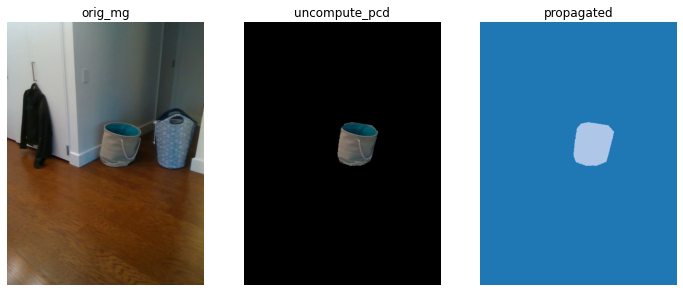

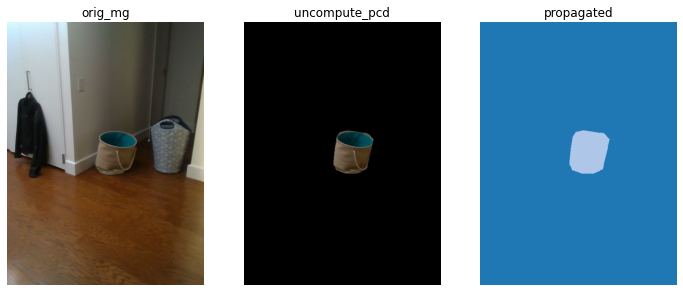

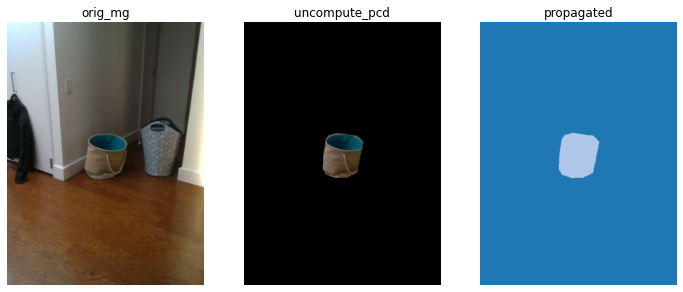

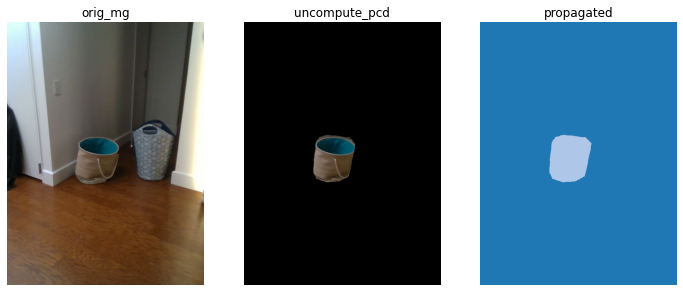

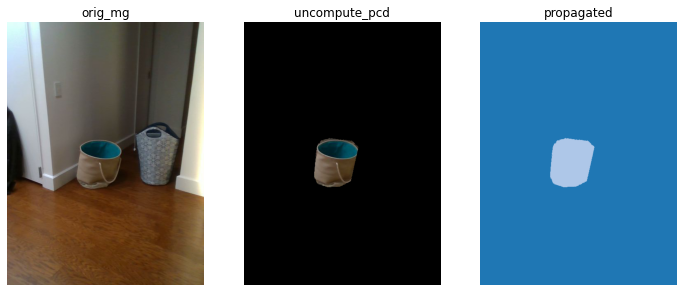

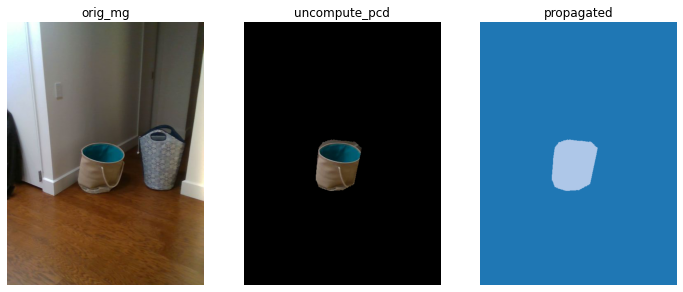

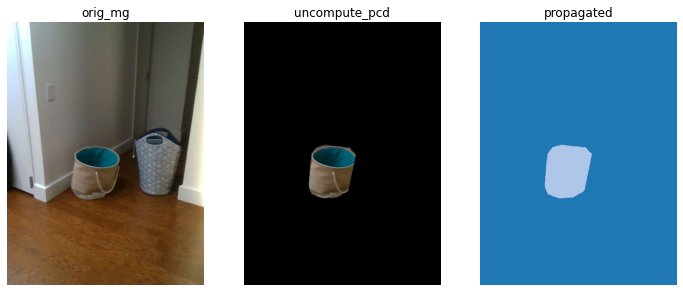

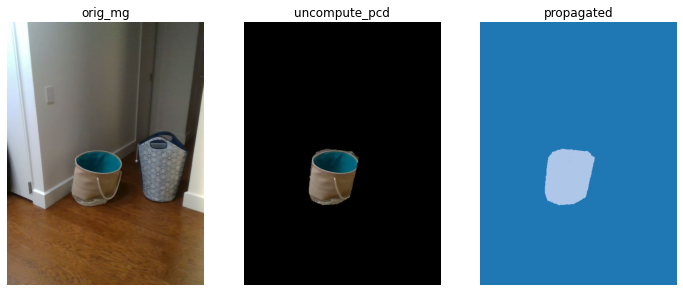

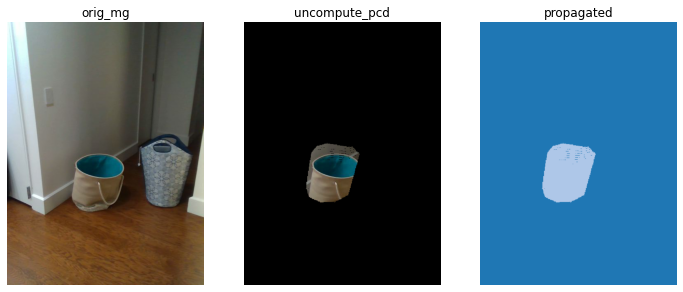

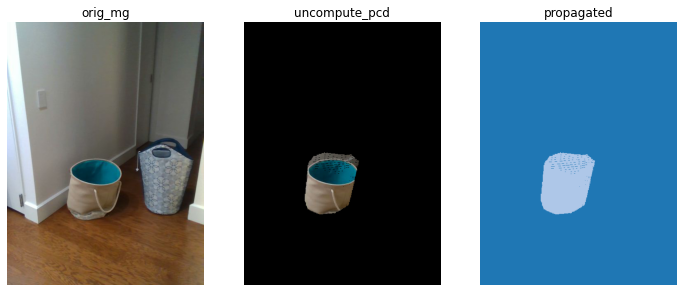

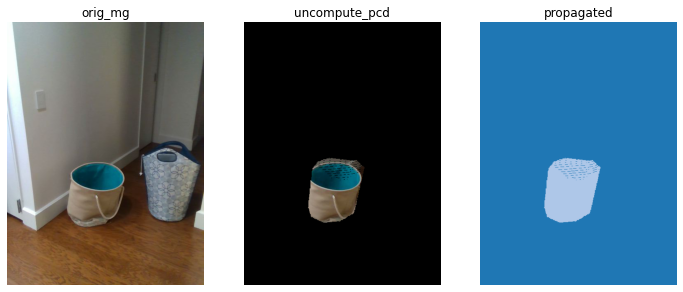

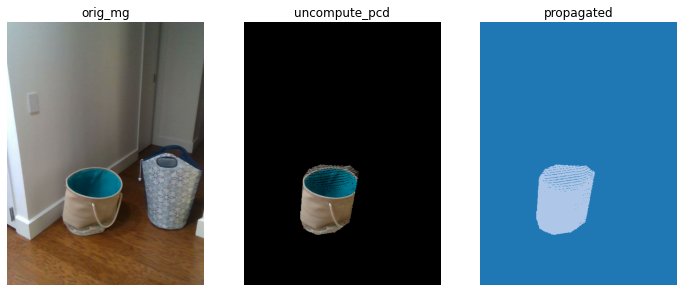

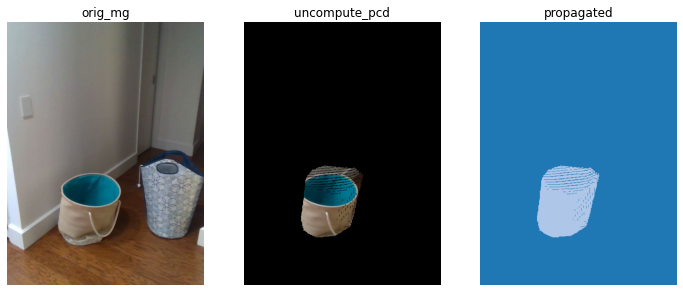

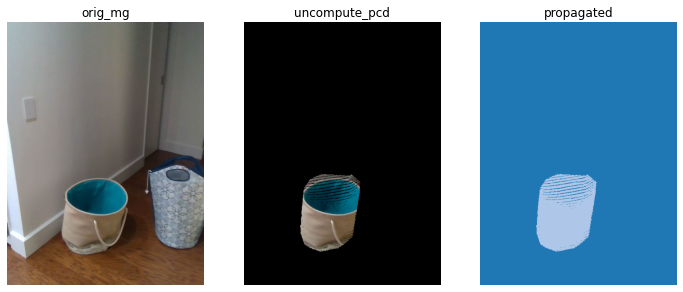

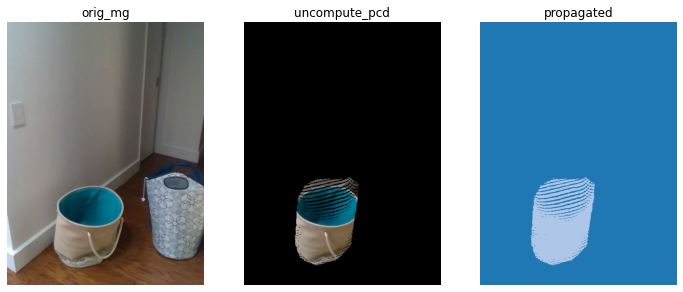

exception found
[Open3D Error] (virtual Eigen::Matrix4d open3d::pipelines::registration::TransformationEstimationForColoredICP::ComputeTransformation(const geometry::PointCloud &, const geometry::PointCloud &, const open3d::pipelines::registration::CorrespondenceSet &) const) /Users/runner/work/Open3D/Open3D/cpp/open3d/pipelines/registration/ColoredICP.cpp:124: No correspondences found between source and target pointcloud.

Failed ICP Registration, so not refining pointcloud


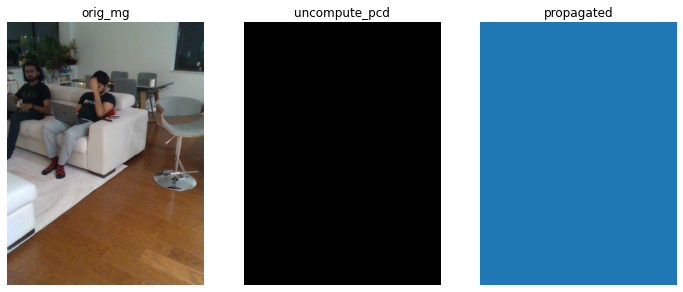

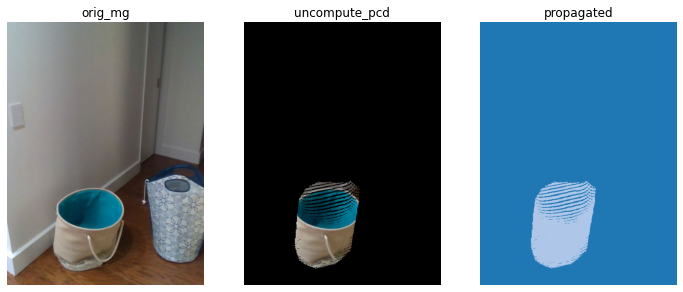

exception found
[Open3D Error] (virtual Eigen::Matrix4d open3d::pipelines::registration::TransformationEstimationForColoredICP::ComputeTransformation(const geometry::PointCloud &, const geometry::PointCloud &, const open3d::pipelines::registration::CorrespondenceSet &) const) /Users/runner/work/Open3D/Open3D/cpp/open3d/pipelines/registration/ColoredICP.cpp:124: No correspondences found between source and target pointcloud.

Failed ICP Registration, so not refining pointcloud


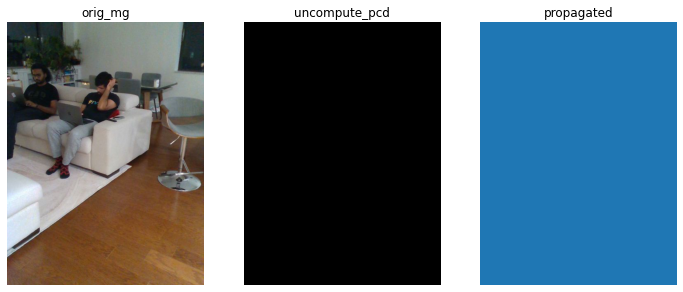

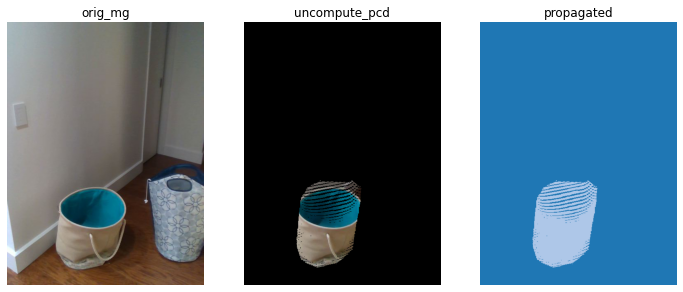

exception found
[Open3D Error] (virtual Eigen::Matrix4d open3d::pipelines::registration::TransformationEstimationForColoredICP::ComputeTransformation(const geometry::PointCloud &, const geometry::PointCloud &, const open3d::pipelines::registration::CorrespondenceSet &) const) /Users/runner/work/Open3D/Open3D/cpp/open3d/pipelines/registration/ColoredICP.cpp:124: No correspondences found between source and target pointcloud.

Failed ICP Registration, so not refining pointcloud


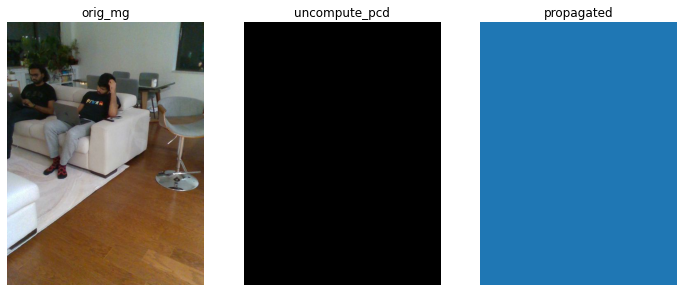

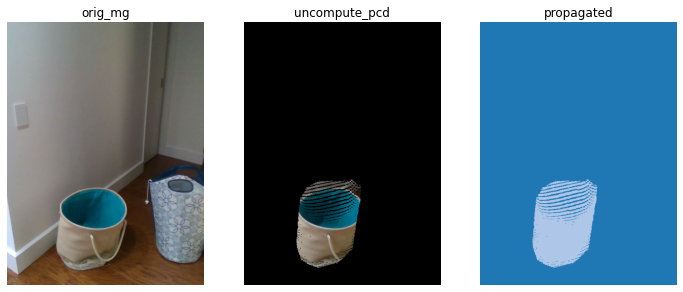

exception found
[Open3D Error] (virtual Eigen::Matrix4d open3d::pipelines::registration::TransformationEstimationForColoredICP::ComputeTransformation(const geometry::PointCloud &, const geometry::PointCloud &, const open3d::pipelines::registration::CorrespondenceSet &) const) /Users/runner/work/Open3D/Open3D/cpp/open3d/pipelines/registration/ColoredICP.cpp:124: No correspondences found between source and target pointcloud.

Failed ICP Registration, so not refining pointcloud


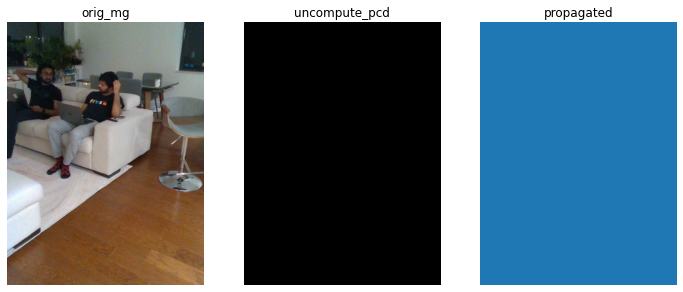

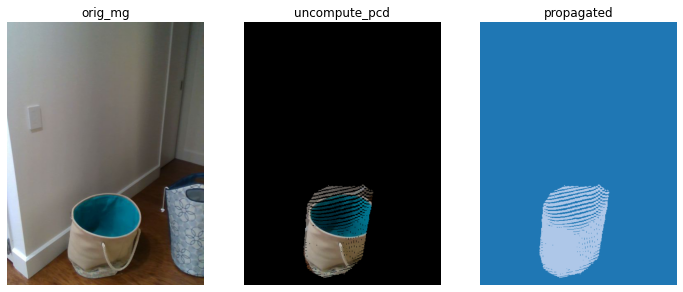

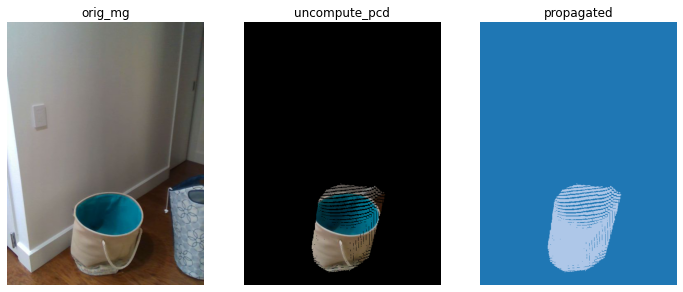

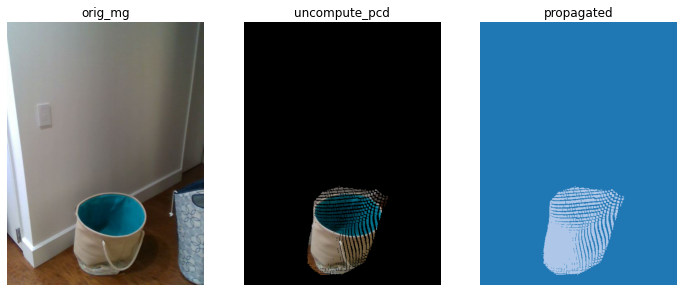

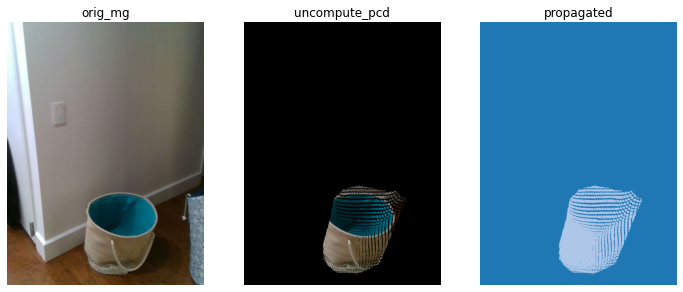

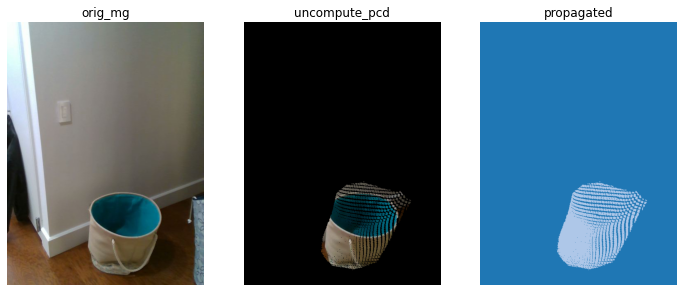

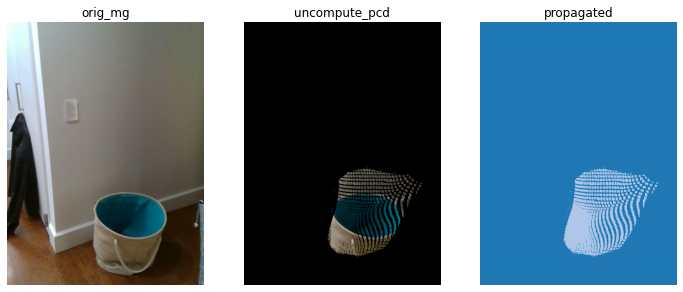

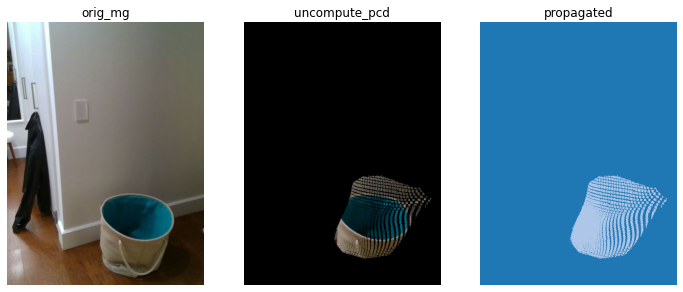

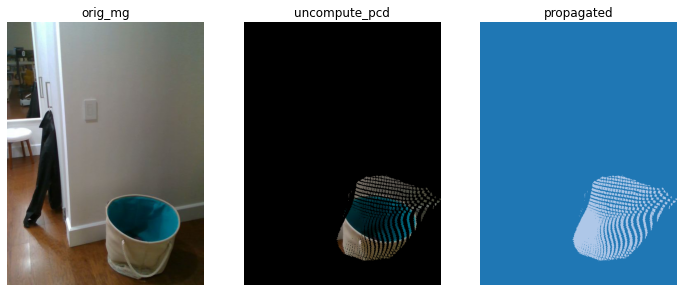

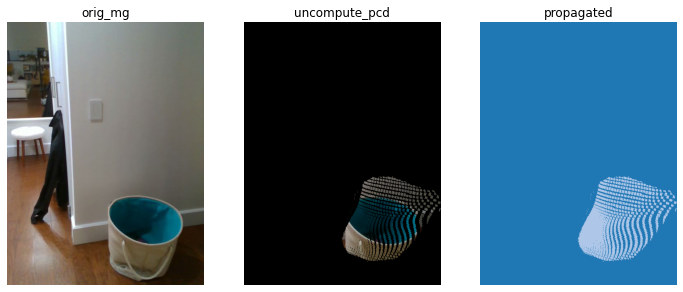

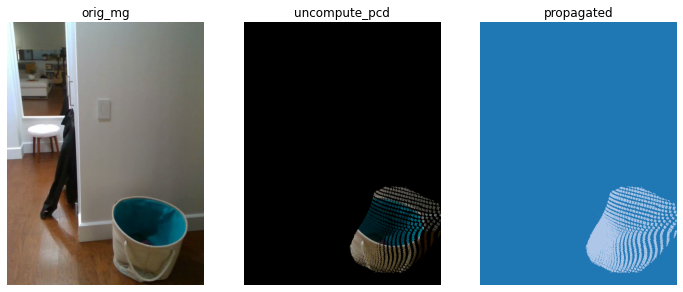

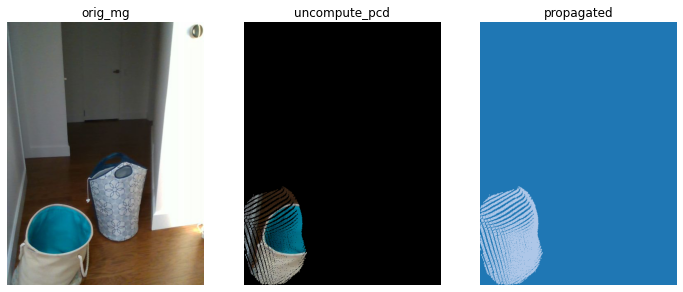

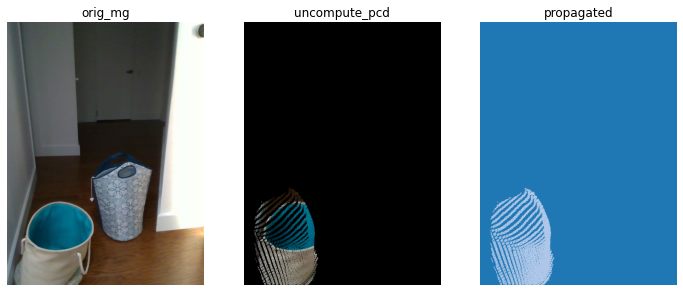

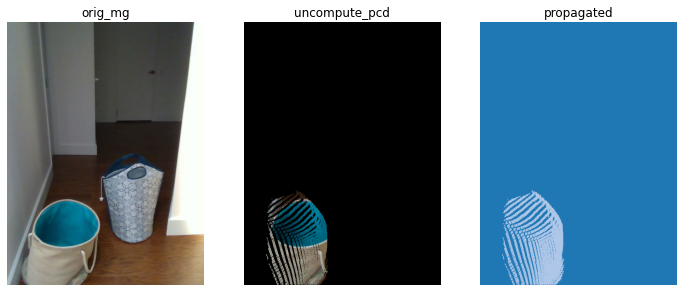

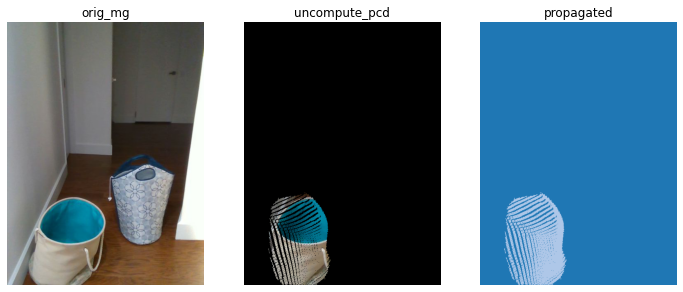

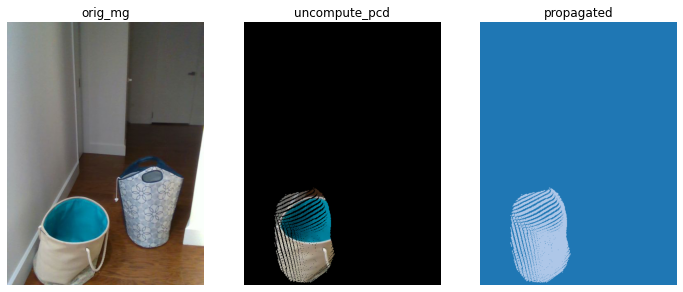

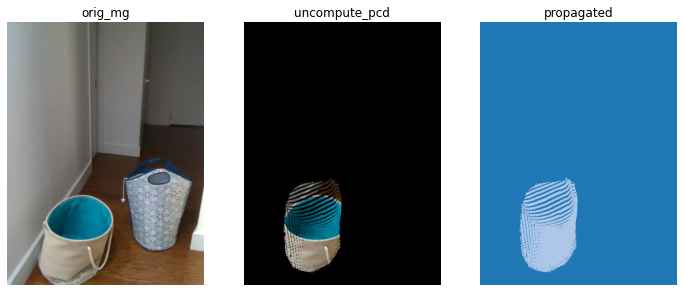

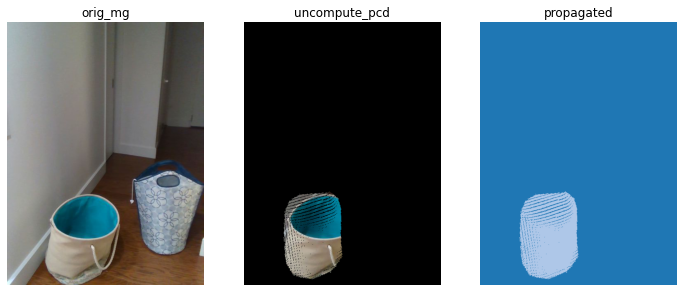

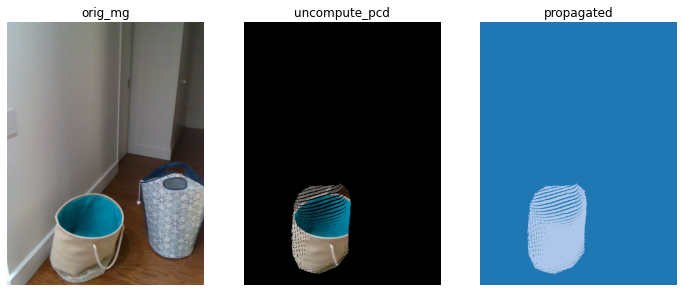

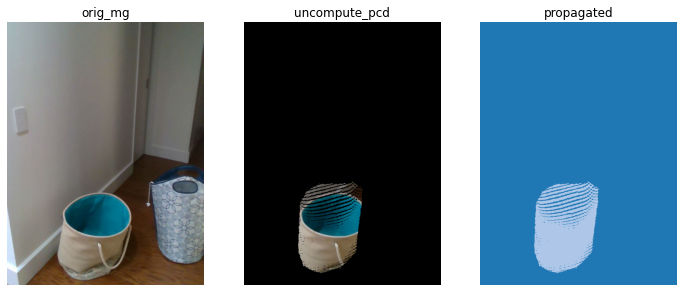

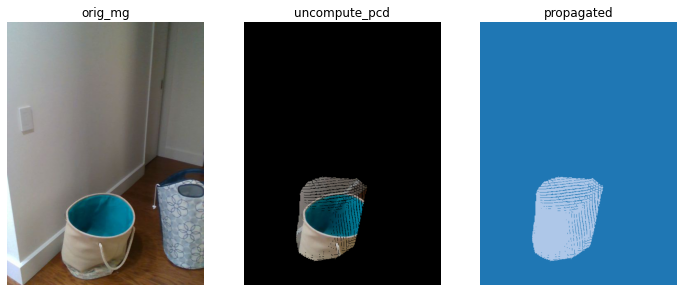

In [21]:
lp = LabelPropagate()
    
for reex_id in ['4']: #reex_data.keys():
    obj_dir = os.path.join(reex_dir, reex_id)
    obj_data = reex_data[reex_id]
    print(f'obj_dir {obj_dir}')
    src_img_indx = obj_data['src_img_id']
    # for each examine heuristic
    
    # load src_img_id rgb, label and pose
    src_img = cv2.imread(os.path.join(explore_dir, "rgb/{:05d}.jpg".format(src_img_indx)))
    src_depth = np.load(os.path.join(explore_dir, "depth/{:05d}.npy".format(src_img_indx)))
    src_pcd = np.load(os.path.join(explore_dir, "pcd/{:05d}.npy".format(src_img_indx)))
    src_label = np.load(os.path.join(explore_dir, "seg/{:05d}.npy".format(src_img_indx)))
    
    src_label = np.rot90(src_label, k=-1, axes=(1, 0))
    src_depth = np.rot90(src_depth, k=-1, axes=(1, 0))
    src_img = np.rot90(src_img, k=-1, axes=(1, 0))
    src_img = src_img[:, :, [2, 1, 0]]

    
    with open(os.path.join(explore_dir, 'data.json'), "r") as f:
        base_pose_data = json.load(f)
    src_pose = base_pose_data["{}".format(src_img_indx)]
    
    # for each heuristic, for each image in rgb, propagate 
    for heu in ['c1pp']:
        heu_dir = os.path.join(obj_dir, heu)
        prop_dir = os.path.join(heu_dir, 'pred')
        print(f'saving propagated frames to {prop_dir}')
        os.makedirs(prop_dir, exist_ok=True)

        num_samples = min(len(os.listdir(os.path.join(heu_dir, 'rgb'))), 50)
        with open(os.path.join(heu_dir, 'data.json'), "r") as f:
            cur_pose_data = json.load(f) 

        # src_pose = [0.0, 0.0, 0.0]
        # cur_pose = [0.0, 1.0, 0.0]
        
        height, width, _ = src_img.shape
#         print(f'height {height} width {width}')
        uv_one_in_cam, intrinsic_mat, rot, trans = compute_uvone(height, width) #640, 480)
        src_pts_in_world = compute_pcd(src_img, src_depth / 1000., rot, trans, src_pose, uv_one_in_cam)
        
        annot_img = lp(src_img, src_depth, src_label, src_pose, src_img, src_depth, src_pose)
        mask = np.zeros(annot_img.shape[:2], dtype="uint8")
        mask[annot_img != 0] = True
        cur_img2 = cv2.bitwise_or(src_img, src_img, mask=mask)
        save_propagated_visual(src_img, cur_img2, annot_img, os.path.join(prop_dir, 'lp_visuals'), 0)

        vis_pcd(src_pts_in_world, src_img, src_pose)
        for p in range(0, num_samples, 1):
            cur_pose = cur_pose_data[str(p)]
#            print("relative_translation", np.array(cur_pose) - np.array(src_pose))
            cur_depth = np.load(os.path.join(heu_dir, "depth/{:05d}.npy".format(p)))    
            cur_img = cv2.imread(os.path.join(heu_dir, "rgb/{:05d}.jpg".format(p)))
                                    
            cur_depth = np.rot90(cur_depth, k=-1, axes=(1, 0))
            cur_img = np.rot90(cur_img, k=-1, axes=(1, 0))
            cur_img = cur_img[:, :, [2, 1, 0]]
            
            cur_pts_in_world = compute_pcd(cur_img, cur_depth / 1000., rot, trans, cur_pose, uv_one_in_cam)
            o3dviz.put("pcd_cur_" + str(p), pcd2o(cur_pts_in_world, cur_img))
            

#             print('src and cur pose', src_pose, cur_pose)
            o3dviz.add_robot(np.array(cur_pose), 1.8, canonical=False, name="new_pose", color=[1.0, 0.0, 0.1])
#             src_pose = [0.0, 0.0, 0.0]
#             cur_pose = [1.0, 0.0, 0.0]
            annot_img = lp(src_img, src_depth, src_label, src_pose, cur_img, cur_depth, cur_pose)
            
#             print(annot_img.shape, annot_img.dtype)
            mask = np.zeros(annot_img.shape[:2], dtype="uint8")
            mask[annot_img != 0] = True
            cur_img2 = cv2.bitwise_or(cur_img, cur_img, mask=mask)

            np.save(os.path.join(prop_dir, "{:05d}.npy".format(p)), annot_img.astype(np.uint32))
            save_propagated_visual(cur_img, cur_img2, annot_img, os.path.join(prop_dir, 'lp_visuals'), p)
